# **Regresión de Ridge**

## **1. Importación de librerías y carga del dataset**

#### **1.1. Importación de librerías**

In [111]:
# Análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de sticky-learn para modelado
from sklearn.model_selection import train_test_split, GridSearchCV, KFold  # Para división de datos y validación
from sklearn.linear_model import Ridge                
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # Para preprocesamiento
from sklearn.compose import ColumnTransformer          # Para aplicar transformaciones a columnas específicas
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer             
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Métricas de evaluación
from scipy import stats # Para pruebas estadísticas

# Modelos de machine learning
import pickle

# Otras utilidades
import math
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

#### **1.2. Cargar el dataset**

In [112]:
df = pd.read_csv('../data/train_es_clean.csv')

# Mostramos información básica sobre el dataset
print(f"Dimensiones del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Visualizamos primeras filas
print("\nVisualización de las primeras filas:")
display(df.head())

Dimensiones del dataset: (1460, 81)
Número de filas: 1460
Número de columnas: 81

Visualización de las primeras filas:


,Id,TipoDeClaseMS,ZonificaciónMS,FrenteLote,ÁreaLote,Calle,Callejón,FormaLote,ContornoTerreno,Servicios,...,ÁreaPiscina,CalidadPiscina,Cerca,CaracterísticaExtra,ValorExtra,MesVenta,AñoVenta,TipoVenta,CondiciónVenta,PrecioVenta
0,1,60,RL,65.0,8450,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NoTiene,Reg,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NoTiene,IR1,Lvl,AllPub,...,0,NoTiene,NoTiene,Ninguna,0,12,2008,WD,Normal,250000


## **2. Exploración inicial de los datos**

#### **2.1. Estadñisticas descriptivas**

In [113]:
# Mostramos las dimensiones y un resumen básico del dataset
print("Dimensiones del dataset:", df.shape)
print(f"Número de propiedades (filas): {df.shape[0]}")
print(f"Número de características (columnas): {df.shape[1]}")

# Estadísticas descriptivas de la variable objetivo
print("\nEstadísticas descriptivas de PrecioVenta:")
precio_stats = df['PrecioVenta'].describe()
print(precio_stats)

Dimensiones del dataset: (1460, 81)
Número de propiedades (filas): 1460
Número de características (columnas): 81

Estadísticas descriptivas de PrecioVenta:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: PrecioVenta, dtype: float64


#### **2.2. Visualización de la distribución de precios**

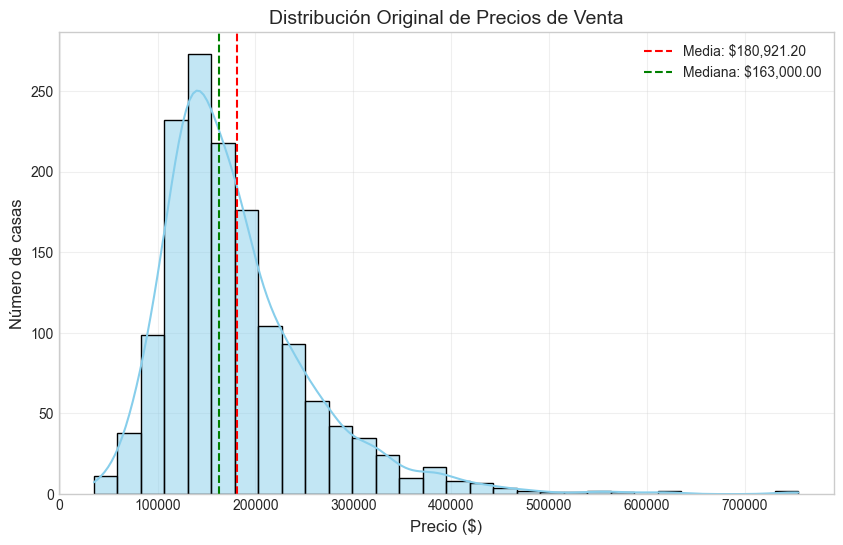

In [114]:
plt.figure(figsize=(10, 6))  
sns.histplot(df['PrecioVenta'], bins=30, kde=True, color='skyblue')  
plt.axvline(precio_stats['mean'], color='red', linestyle='--', 
            label=f'Media: ${precio_stats["mean"]:,.2f}')  
plt.axvline(precio_stats['50%'], color='green', linestyle='--', 
            label=f'Mediana: ${precio_stats["50%"]:,.2f}')  
plt.title('Distribución Original de Precios de Venta', fontsize=14)  
plt.xlabel('Precio ($)', fontsize=12)  
plt.ylabel('Número de casas', fontsize=12)  
plt.legend()  
plt.grid(True, alpha=0.3)  
plt.show()  

<small>

Interpretación:
1. Asimetría positiva (sesgo a la derecha): La distribución muestra una clara cola larga hacía la derecha. La mayoría de precios están entre 100.000 y 200.000.
2. Diferencia entre media y mediana: La media es mayor que la mediana, confirmando matetmáticamente la asimetría positiva. Los valores extremadamente positivos suben la media, mientras que la mediana es más robusta frente a outliers.
3. Concentración de los datos: Mayor densidad de propiedades se encuentran en el rango entre 125.000 - 200.000, con un pico en el medio de 150.000.
4. Rango amplio: La distribución muestra una amplia gama de precios, con una mayor concentración de precios por debajo de 300.000 y una menor concentración de precios por encima de 500.000.

</small>

#### **2.3. Cálculo de asimetría y curtosis**

In [115]:
asimetria = df['PrecioVenta'].skew()
curtosis = df['PrecioVenta'].kurtosis()

print(f"Asimetria (skewness) de PrecioVenta: {asimetria:.4f}")
print(f"Curtosis de PrecioVenta: {curtosis:.4f}")

Asimetria (skewness) de PrecioVenta: 1.8829
Curtosis de PrecioVenta: 6.5363


<small>

Con el cálculo de asimetría y curtosis confirmamos lo visto en el histograma:
1. Asimetría (1.8829): Distribución fuertemente sesgada hacía la derecha. Muchas propiedades de precio  bajo-medio y relativamente pocas de precio alto que estiran la distribución.
2. Curtosis (6.5363): Distribución más puntiaguda de lo normal con colas más pesadas (distribución leptocúrtica)

Es recomendable hacer una transformación logarítmica de la variable objetivo con el objetivo de:
1. "Comprimir" los valores altos, reduciendo la asimetría.
2. Hacer que la la relación entre las variables independientes y el precio sea más lineal.
3. Estabilizar la varianza de los residuos.
4. Mejorar la precisión del modelo, especialmente para las propiedades de precio más bajo.

</small>

#### **2.4. Transformación logarítmica de la variable objetivo**


Estadísticas descriptivas de PrecioVenta (transformación logarítmica):
count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: PrecioVenta_Log, dtype: float64


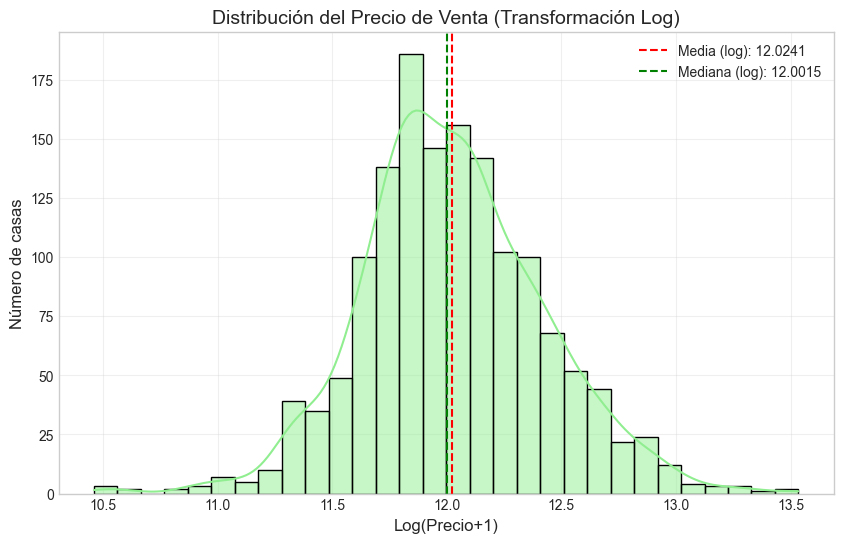


Asimetría después de transformación logarítmica: 0.1213
Curtosis después de transformación logarítmica: 0.8095


In [116]:
# Aplicamos transformación logarítmica y visualizamos
# Utilizamos log1p (log(1+x)) en lugar de log para manejar posibles valores cero
df['PrecioVenta_Log'] = np.log1p(df['PrecioVenta'])

# Mostramos estadísticas descriptivas después de la transformación
print("\nEstadísticas descriptivas de PrecioVenta (transformación logarítmica):")
print(df['PrecioVenta_Log'].describe())

# Visualizamos la distribución después de la transformación
plt.figure(figsize=(10, 6))
sns.histplot(df['PrecioVenta_Log'], bins=30, kde=True, color='lightgreen')
plt.axvline(df['PrecioVenta_Log'].mean(), color='red', linestyle='--', 
            label=f'Media (log): {df["PrecioVenta_Log"].mean():.4f}')
plt.axvline(df['PrecioVenta_Log'].median(), color='green', linestyle='--', 
            label=f'Mediana (log): {df["PrecioVenta_Log"].median():.4f}')
plt.title('Distribución del Precio de Venta (Transformación Log)', fontsize=14)
plt.xlabel('Log(Precio+1)', fontsize=12)
plt.ylabel('Número de casas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculamos la asimetría y curtosis después de la transformación
asimetria_log = df['PrecioVenta_Log'].skew()
curtosis_log = df['PrecioVenta_Log'].kurtosis()
print(f"\nAsimetría después de transformación logarítmica: {asimetria_log:.4f}")
print(f"Curtosis después de transformación logarítmica: {curtosis_log:.4f}")

<small>

Interpretación de la Transformación Logarítmica

La transformación logarítmica ha mejorado drasticamente la distribución de nuestra variable objetivo:

1. Forma: Ahora tenemos una distribución casi simétrica en forma de campana, mucho más cercana a una normal.
2. Media y mediana: Las líneas vertical roja (media: 12.02) y verde (mediana: 12.00) están ahora prácticamente superpuestas, confirmando la simetría.
3. Métricas estadísticas: La asimetría se redujo de 1.88 a solo 0.12, y la curtosis bajó de 6.54 a 0.81, ambos valores mucho más cercanos a lo esperado en una distribución normal.
4. Beneficios para nuestro modelo Ridge: Esta transformación permitirá que nuestro modelo cumpla mejor con los supuestos estadísticos, sea menos sensible a valores extremos y ofrezca predicciones más precisas en todo el rango de precios.

</small>

## **3. Análisis de Variables Predictoras**

#### **3.1. Variables numéricas importantes**

Correlaciones con el precio transformado (log):
PrecioVenta_Log                 1.000000
CalidadGeneral                  0.817185
MetrosHabitables                0.700927
CochesGaraje                    0.680625
ÁreaGaraje                      0.650888
MetrosTotalesSótano             0.612134
Metros1raPlanta                 0.596981
BañosCompletos                  0.594771
AñoConstrucción                 0.586570
AñoRenovación                   0.565608
TotalHabitacionesSobreSuelo     0.534422
Chimeneas                       0.489450
ÁreaRevestimientoMampostería    0.426776
MetrosAcabadosSótano1           0.372023
FrenteLote                      0.335292
Name: PrecioVenta_Log, dtype: float64


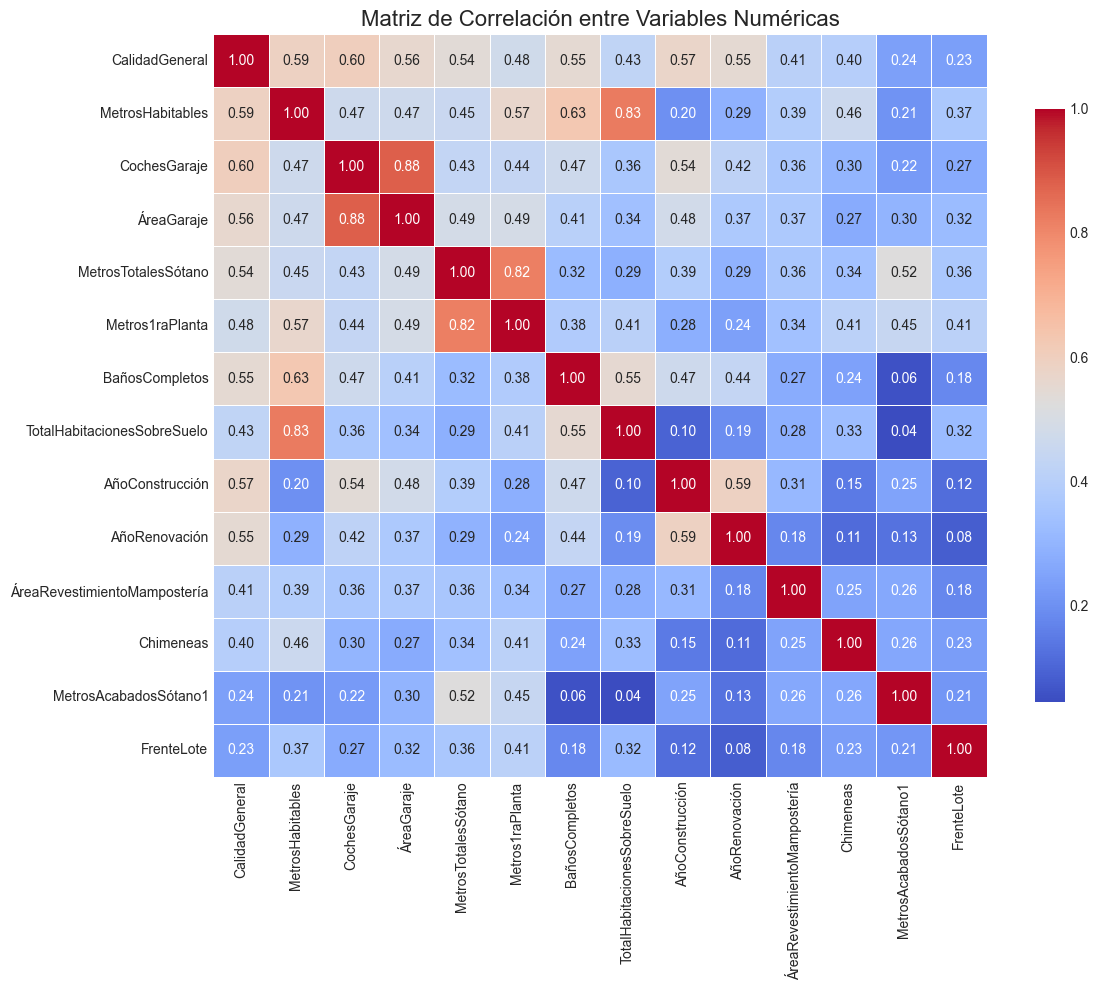

In [117]:
vars_num_importantes = [
    'CalidadGeneral',
    'MetrosHabitables',
    'CochesGaraje', 
    'ÁreaGaraje', 
    'MetrosTotalesSótano',
    'Metros1raPlanta',
    'BañosCompletos',
    'TotalHabitacionesSobreSuelo',
    'AñoConstrucción',
    'AñoRenovación',
    'ÁreaRevestimientoMampostería',
    'Chimeneas',
    'MetrosAcabadosSótano1',
    'FrenteLote'
]

# Verificamos la correlación entre estas variables numéricas y el precio transformado
correlaciones = df[vars_num_importantes + ['PrecioVenta_Log']].corr()['PrecioVenta_Log'].sort_values(ascending=False)
print("Correlaciones con el precio transformado (log):")
print(correlaciones)

# Creamos una matriz de correlación para examinar la multicolinealidad
plt.figure(figsize=(12, 10))
sns.heatmap(df[vars_num_importantes].corr(), annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

<small>

Interpretación de las Correlaciones

La matriz de correlación revela patrones importantes en nuestros datos. Después de la transformación logarítmica, las correlaciones con el precio generalmente aumentaron (CalidadGeneral subió de 0.79 a 0.82), confirmando el beneficio de esta transformación.

Encontramos varias correlaciones altas entre predictores (como el 0.88 entre CochesGaraje y ÁreaGaraje), lo que indica multicolinealidad. Esta característica justifica el uso de Ridge, ya que esta técnica está específicamente diseñada para manejar variables correlacionadas, evitando la inestabilidad que causarían en una regresión lineal simple.

La persistencia del orden de importancia de las variables después de la transformación logarítmica confirma que nuestra selección inicial de predictores sigue siendo válida para nuestro modelo.

</small>

#### **3.2. Análisis de Variables Categóricas** 

#### **3.2.1. Identificar variables categóricas e investigar su cardinalidad**

In [118]:
vars_categoricas = df.select_dtypes(include=['object']).columns.tolist()

# Analizamos la cardinalidad (número de categorías únicas) de cada variable
print(f"Total de variables categóricas: {len(vars_categoricas)}")
print("\nCardinalidad de variables categóricas:")

# Creamos un DataFrame para visualizar mejor la información de cardinalidad
cardinalidad = pd.DataFrame({
    'Variable': vars_categoricas,
    'Categorías_Únicas': [df[var].nunique() for var in vars_categoricas]
})
cardinalidad = cardinalidad.sort_values('Categorías_Únicas', ascending=False)

# Mostramos las variables categóricas ordenadas por número de categorías
print(cardinalidad)

Total de variables categóricas: 43

Cardinalidad de variables categóricas:
                        Variable  Categorías_Únicas
8                     Vecindario                 25
16                     Exterior2                 16
15                     Exterior1                 15
9                     Condición1                  9
41                     TipoVenta                  9
12                    EstiloCasa                  8
14                 MaterialTecho                  8
10                    Condición2                  8
25            TipoAcabadoSótano2                  7
24            TipoAcabadoSótano1                  7
33                    TipoGaraje                  7
31                 Funcionalidad                  7
26                   Calefacción                  6
42                CondiciónVenta                  6
36               CondiciónGaraje                  6
32               CalidadChimenea                  6
35                 CalidadGaraje         

#### **3.2.2. Aplicar pruebas ANOVA para seleccionar variables categóricas significativas**

In [119]:
# Creamos un DataFrame para almacenar los resultados de las pruebas ANOVA
resultados_anova = []

# Analizamos cada variable categórica usando ANOVA
for var in vars_categoricas:
    # Agrupamos los datos por cada categoría
    grupos = []
    for categoria in df[var].unique():
        # Extraemos los precios logarítmicos para esta categoría
        grupo = df[df[var] == categoria]['PrecioVenta_Log'].values
        grupos.append(grupo)
    
    # Realizamos la prueba ANOVA si hay al menos dos grupos con datos
    if len(grupos) >= 2 and all(len(g) > 0 for g in grupos):
        # La función f_oneway realiza la prueba ANOVA de un factor
        f_valor, p_valor = stats.f_oneway(*grupos)
        
        # Guardamos los resultados
        resultados_anova.append({
            'Variable': var,
            'F_valor': f_valor,
            'P_valor': p_valor,
            'Categorias': df[var].nunique(),
            'Significativa': p_valor < 0.05
        })

# Convertimos los resultados a un DataFrame para mejor visualización
df_anova = pd.DataFrame(resultados_anova)

# Ordenamos por valor F (mayor efecto) para variables significativas
df_anova_sig = df_anova[df_anova['Significativa']].sort_values('F_valor', ascending=False)
print("Variables categóricas con efecto significativo en el precio (ordenadas por importancia):")
print(df_anova_sig[['Variable', 'F_valor', 'P_valor', 'Categorias']])

# Seleccionamos las variables categóricas más significativas
# Tomamos las top 10 variables con mayor valor F (mayor efecto)
vars_cat_significativas = df_anova_sig['Variable'].head(10).tolist()
print("\nTop 10 variables categóricas seleccionadas para el modelo:")
print(vars_cat_significativas)

Variables categóricas con efecto significativo en el precio (ordenadas por importancia):
                        Variable     F_valor        P_valor  Categorias
18               CalidadExterior  415.304259  6.930372e-195           4
30                 CalidadCocina  393.320922  4.438817e-187           4
21                 CalidadSótano  300.392915  2.029970e-188           5
34                 AcabadoGaraje  298.769591  4.058066e-151           4
28      AireAcondicionadoCentral  205.666008   9.859878e-44           2
32               CalidadChimenea  131.198588  6.961918e-115           6
20                   Cimentación  126.806779  1.350599e-111           6
33                    TipoGaraje  121.796238  8.430356e-125           7
17  TipoRevestimientoMampostería  112.474438   1.669801e-65           4
27            CalidadCalefacción  110.820423   1.614912e-82           5
8                     Vecindario   79.520526  4.041201e-243          25
0                 ZonificaciónMS   77.607607   

<small>
Interpretación de los Resultados ANOVA

El análisis ANOVA nos muestra qué variables categóricas tienen mayor influencia estadística sobre el precio de las viviendas:

1. Las variables de calidad (CalidadExterior, CalidadCocina, CalidadSótano) encabezan la lista con valores F muy altos, indicando que estas características son determinantes principales del precio.
2. El valor F mide cuánto varía el precio entre diferentes categorías de una variable. Valores más altos significan mayor influencia en el precio.
3. El p-valor extremadamente bajo (cercano a cero) para todas estas variables confirma que la relación no es por azar, sino estadísticamente significativa.
4. Aunque Vecindario aparece en la posición 11, su p-valor extraordinariamente bajo (4.04e-243) destaca su importancia, reflejando las marcadas diferencias de precio entre las 25 zonas.

</small>

#### **3.2.3. Aplicar codificación one-hot a las variables categóricas seleccionadas**

In [120]:
# Usamos las variables categóricas más significativas identificadas por ANOVA
vars_cat_significativas = ['CalidadExterior', 'CalidadCocina', 'CalidadSótano', 
                           'AcabadoGaraje', 'AireAcondicionadoCentral', 'CalidadChimenea', 
                           'Cimentación', 'TipoGaraje', 'TipoRevestimientoMampostería', 
                           'CalidadCalefacción', 'Vecindario']

# Creamos una copia del dataframe para no modificar el original
df_encoded = df.copy()

# Aplicamos One-Hot Encoding a las variables categóricas seleccionadas
for var in vars_cat_significativas:
    # Creamos variables dummy y eliminamos una categoría para evitar multicolinealidad perfecta
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=True)
    
    # Añadimos las variables dummy al dataframe
    df_encoded = pd.concat([df_encoded, dummies], axis=1)

# Verificamos cuántas nuevas columnas hemos creado
nuevas_columnas = [col for col in df_encoded.columns if col not in df.columns]
print(f"Se han creado {len(nuevas_columnas)} nuevas columnas después del encoding")
print(f"Ejemplo de nuevas columnas: {nuevas_columnas[:5]}...")

Se han creado 61 nuevas columnas después del encoding
Ejemplo de nuevas columnas: ['CalidadExterior_Fa', 'CalidadExterior_Gd', 'CalidadExterior_TA', 'CalidadCocina_Fa', 'CalidadCocina_Gd']...


## **4. Análisis de correlaciones entre variables codificadas y el precio**

Correlación con el precio logarítmico:
PrecioVenta_Log            1.000000
CalidadExterior_TA        -0.595882
CalidadCocina_TA          -0.538237
Cimentación_PConc          0.530840
CalidadChimenea_NoTiene   -0.510026
                             ...   
TipoGaraje_Basment        -0.030945
Vecindario_Blueste        -0.018320
Cimentación_Stone         -0.014622
Cimentación_Wood           0.008912
CalidadChimenea_Fa        -0.005919
Name: PrecioVenta_Log, Length: 62, dtype: float64


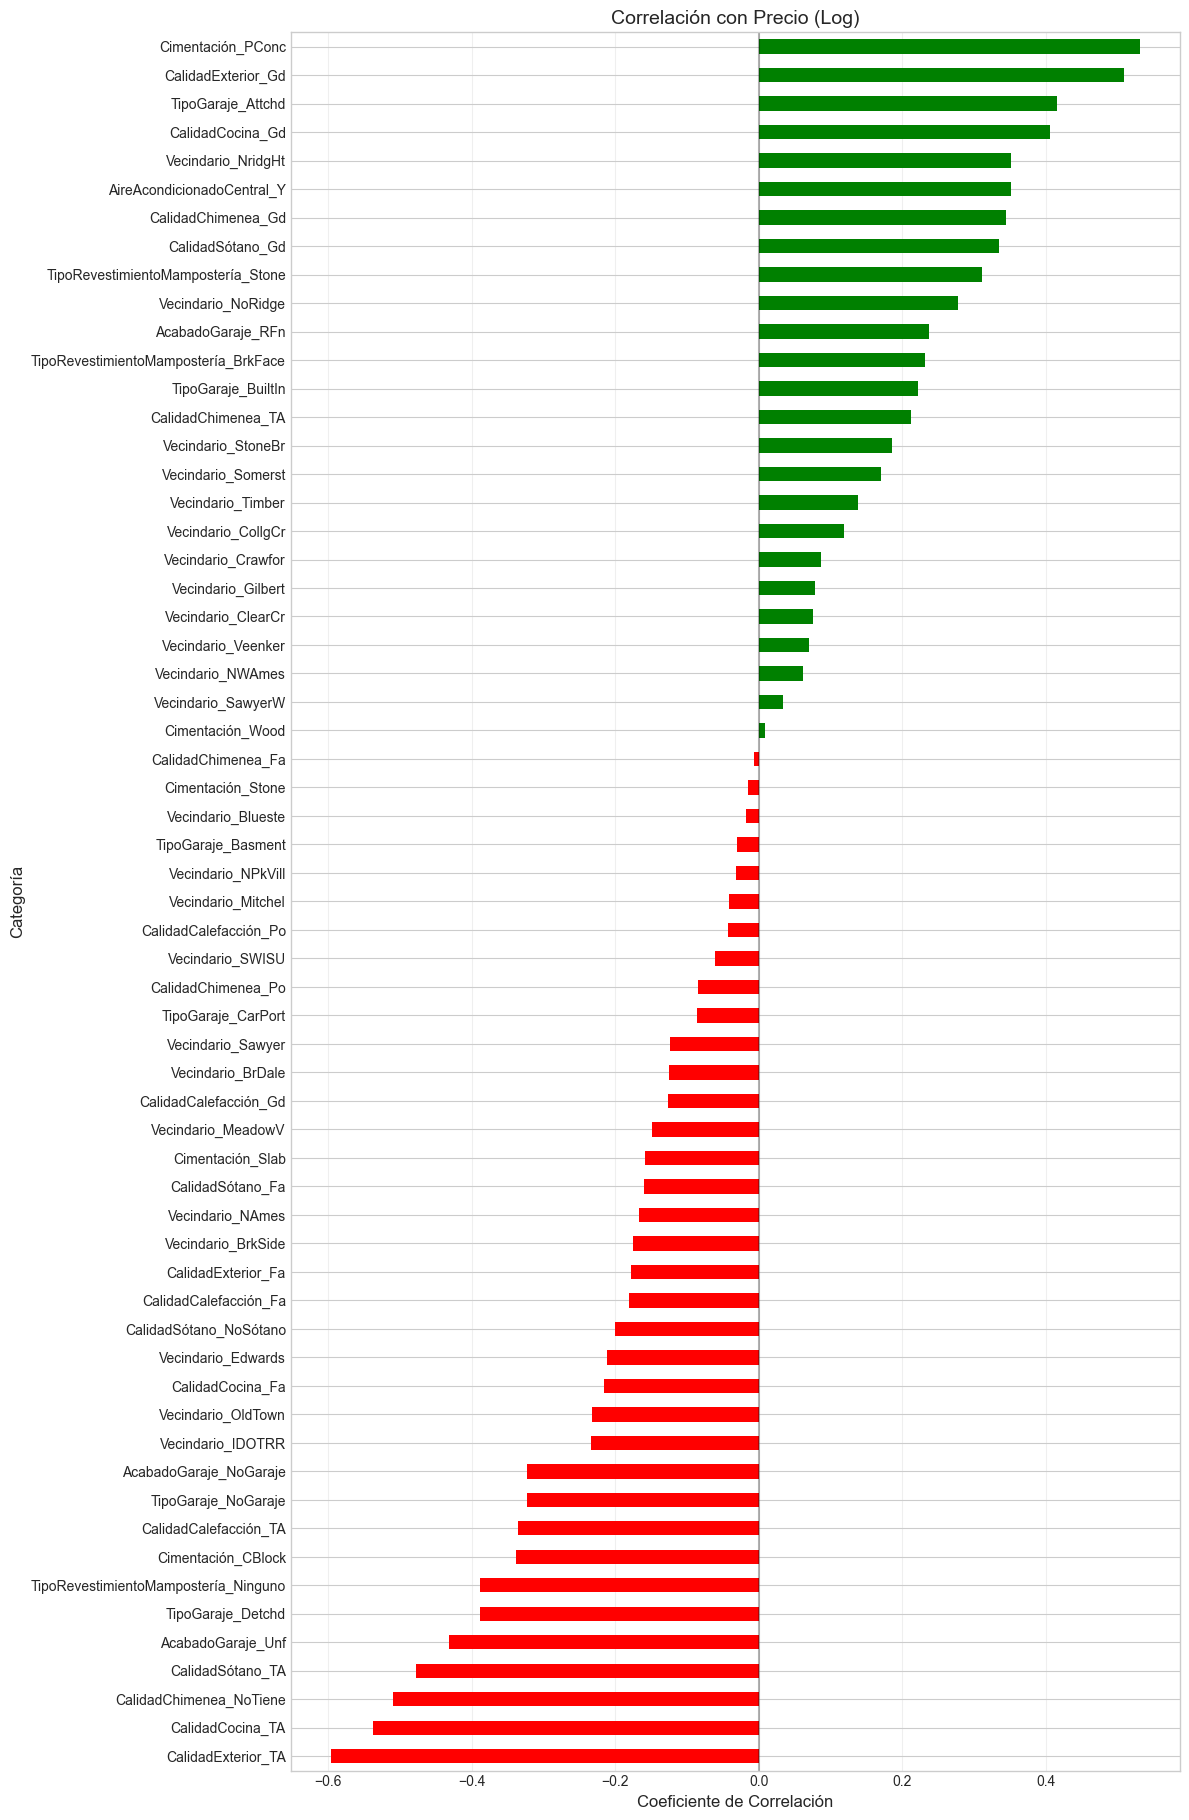

In [121]:
# Calculamos correlaciones entre las nuevas variables codificadas y el precio logarítmico
correlaciones_categoricas = df_encoded[nuevas_columnas + ['PrecioVenta_Log']].corr()['PrecioVenta_Log']

# Ordenamos las correlaciones de mayor a menor (en valor absoluto)
correlaciones_abs = correlaciones_categoricas.abs().sort_values(ascending=False)

# Mostramos todas las correlaciones con el precio logarítmico
print("Correlación con el precio logarítmico:")
print(correlaciones_categoricas[correlaciones_abs.index])

# Seleccionamos todas las correlaciones (menos el propio PrecioVenta_Log, si quieres)
correlaciones_top = correlaciones_categoricas[correlaciones_abs.index].drop('PrecioVenta_Log')

# Visualizamos las correlaciones en un gráfico de barras
plt.figure(figsize=(12, max(6, len(correlaciones_top) * 0.3)))  # ajusta el alto según cantidad

# Ordenamos por valor de correlación para mejor visualización
correlaciones_top = correlaciones_top.sort_values()

# Colores: verde para positivas, rojo para negativas
colores = ['red' if x < 0 else 'green' for x in correlaciones_top]
correlaciones_top.plot(kind='barh', color=colores)

plt.title('Correlación con Precio (Log)', fontsize=14)
plt.xlabel('Coeficiente de Correlación', fontsize=12)
plt.ylabel('Categoría', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


<small>

Correlaciones con el Precio de Viviendas

El gráfico muestra qué características están más asociadas con precios más 
altos o más bajos:

1. Factores que aumentan el precio: Cimentación de hormigón, calidad exterior excelente, garaje adosado y vecindarios premium (NridgHt, NoRidge).
2. Factores que disminuyen el precio: Acabados de calidad promedio, ausencia de elementos valorados (como chimenea o garaje), y ubicación en vecindarios menos cotizados.

</small>

## **5. Preparación para el Modelado Ridge**

#### **5.1. Definición del conjunto completo de predictores**

In [122]:
vars_num_importantes = [
    'CalidadGeneral',
    'MetrosHabitables',
    'CochesGaraje',
    'ÁreaGaraje',
    'MetrosTotalesSótano',
    'Metros1raPlanta',
    'BañosCompletos',
    'TotalHabitacionesSobreSuelo',
    'AñoConstrucción',
    'AñoRenovación',
    'ÁreaRevestimientoMampostería',
    'Chimeneas',
    'MetrosAcabadosSótano1',
    'FrenteLote' ]

# Verificamos que todas las variables numéricas están en el DataFrame
for var in vars_num_importantes:
    if var not in df.columns:
        print(f"Advertencia: La variable {var} no se encuentra en el dataset")

# Creamos el conjunto de predictores X combinando variables numéricas y categóricas codificadas
X = df_encoded[vars_num_importantes + nuevas_columnas]

# La variable objetivo y es el precio en escala logarítmica
y = df_encoded['PrecioVenta_Log']

# Verificamos las dimensiones de nuestro conjunto de datos
print(f"Dimensiones del conjunto de predictores (X): {X.shape}")
print(f"Dimensiones de la variable objetivo (y): {y.shape}")
print(f"Número total de predictores: {X.shape[1]}")

Dimensiones del conjunto de predictores (X): (1460, 75)
Dimensiones de la variable objetivo (y): (1460,)
Número total de predictores: 75


#### **5.2. División en conjuntos de entrenamiento y prueba**

In [123]:
# Dividimos los datos en cojuntos de entrenamiento (80%) y prueba (20%)
# Usamos random_state=42 para que la división sea reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 1168 muestras
Tamaño del conjunto de prueba: 292 muestras


#### **5.3. Estandarización de variables numéricas**

In [124]:
# Identificamos las columnas numéricas en nuestro conjunto de predictores
# No es necesario estandarizar las variables dummy que ya están en escala 0-1
columnas_numericas = vars_num_importantes
 
# Creamos y ajustamos el scaler solo con el conjunto de entrenamiento
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Estandarizamos solo las columnas numéricas
X_train_scaled[columnas_numericas] = scaler.fit_transform(X_train[columnas_numericas])
X_test_scaled[columnas_numericas] = scaler.transform(X_test[columnas_numericas])

# Verificamos la media y desviación estándar de las variables estandarizadas
print("\nVerificación de estandarización (medias cercanas a 0, desv. estándar cercanas a 1):")
print(X_train_scaled[columnas_numericas].describe().loc[['mean', 'std'], :].round(2))


Verificación de estandarización (medias cercanas a 0, desv. estándar cercanas a 1):
      CalidadGeneral  MetrosHabitables  CochesGaraje  ÁreaGaraje  \
mean            -0.0              -0.0           0.0         0.0   
std              1.0               1.0           1.0         1.0   

      MetrosTotalesSótano  Metros1raPlanta  BañosCompletos  \
mean                  0.0              0.0            -0.0   
std                   1.0              1.0             1.0   

      TotalHabitacionesSobreSuelo  AñoConstrucción  AñoRenovación  \
mean                         -0.0             -0.0            0.0   
std                           1.0              1.0            1.0   

      ÁreaRevestimientoMampostería  Chimeneas  MetrosAcabadosSótano1  \
mean                          -0.0        0.0                    0.0   
std                            1.0        1.0                    1.0   

      FrenteLote  
mean         0.0  
std          1.0  


## **6. Implementación del Modelo Ridge**

#### **6.1. Búsqueda del parámetro alpha óptimo mediante validación cruzada**

In [125]:
# Definimos una gama de valores de alpha para probar
alphas = np.logspace(-3, 3, 100)  # 100 valores entre 0.001 y 1000 en escala logarítmica

# Configuramos la búsqueda de hiperparámetros con validación cruzada
# La clave es usar n_jobs=1 para evitar problemas de paralelización
ridge_cv = GridSearchCV(
    Ridge(random_state=42),  # Modelo base
    param_grid={'alpha': alphas},  # Parámetros a probar
    cv=5,  # Número de divisiones para validación cruzada
    scoring='neg_mean_squared_error',  # Métrica a optimizar
    n_jobs=1  # Usar un solo núcleo para evitar errores de paralelización
)

# Ajustamos el modelo para encontrar el mejor alpha
print("Buscando el valor óptimo de alpha mediante validación cruzada...")
ridge_cv.fit(X_train_scaled, y_train)

# Mostramos el mejor valor de alpha encontrado
best_alpha = ridge_cv.best_params_['alpha']
print(f"Mejor valor de alpha: {best_alpha:.6f}")
print(f"Mejor puntuación MSE de validación cruzada: {-ridge_cv.best_score_:.6f}")

Buscando el valor óptimo de alpha mediante validación cruzada...
Mejor valor de alpha: 1.232847
Mejor puntuación MSE de validación cruzada: 0.025298


#### **6.2. Entrenamiento del modelo final con el mejor alpha**

In [126]:
# Entrenamos el modelo Ridge final con el mejor valor de alpha
ridge_final = Ridge(alpha=best_alpha, random_state=42)
ridge_final.fit(X_train_scaled, y_train)

# Clase mejorada con doble funcionalidad (log y dólares)
class DollarRidgeModel:
    def __init__(self, model, scaler=None, feature_names=None):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names  # Para validación opcional
    
    def predict(self, X, return_log=False):
        """
        Predicciones principales:
        - return_log=False: Devuelve dólares (para producción)
        - return_log=True: Devuelve log (para evaluación)
        """
        pred = self.model.predict(X)
        return pred if return_log else np.expm1(pred)
    
    def get_original_model(self):
        return self.model

# Creamos la instancia con capacidad de validación
dollar_ridge = DollarRidgeModel(
    model=ridge_final,
    scaler=scaler,
    feature_names=vars_num_importantes + nuevas_columnas
)

# Predicciones (ahora usando el método unificado)
y_pred_log = dollar_ridge.predict(X_test_scaled, return_log=True)  # Escala log
y_pred_orig = dollar_ridge.predict(X_test_scaled)                 # Dólares
y_test_orig = np.expm1(y_test)                                   # Conversión test

# Cálculo de métricas (igual que antes)
metrics = {
    'log': {
        'MSE': mean_squared_error(y_test, y_pred_log),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_log)),
        'R2': r2_score(y_test, y_pred_log),
        'MAE': mean_absolute_error(y_test, y_pred_log)
    },
    'dollar': {
        'MSE': mean_squared_error(y_test_orig, y_pred_orig),
        'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),
        'R2': r2_score(y_test_orig, y_pred_orig),
        'MAE': mean_absolute_error(y_test_orig, y_pred_orig),
        'RMSE_%': (np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)) / y_test_orig.mean()) * 100
    }
}

# Resultados
print("=== Métricas en Escala Logarítmica ===")
print(f"MSE: {metrics['log']['MSE']:.6f}")
print(f"RMSE: {metrics['log']['RMSE']:.6f}")
print(f"R²: {metrics['log']['R2']:.6f}")
print(f"MAE: {metrics['log']['MAE']:.6f}\n")

print("=== Métricas en Dólares ===")
print(f"MSE: ${metrics['dollar']['MSE']:,.2f}")
print(f"RMSE: ${metrics['dollar']['RMSE']:,.2f}")
print(f"R²: {metrics['dollar']['R2']:.6f}")
print(f"MAE: ${metrics['dollar']['MAE']:,.2f}")
print(f"Error relativo: {metrics['dollar']['RMSE_%']:.2f}% del precio promedio")

=== Métricas en Escala Logarítmica ===
MSE: 0.022006
RMSE: 0.148345
R²: 0.882075
MAE: 0.105684

=== Métricas en Dólares ===
MSE: $810,507,883.40
RMSE: $28,469.42
R²: 0.894332
MAE: $18,558.12
Error relativo: 15.92% del precio promedio


<small>

Resumen de Resultados del Modelo Ridge

El modelo de regresión Ridge construido para predecir precios de viviendas demuestra un sólido rendimiento predictivo. Con un R² de 0.89, el modelo explica casi el 90% de la variabilidad en los precios inmobiliarios, lo que representa un resultado muy positivo para este tipo de datos.

En términos prácticos, las predicciones tienen un error promedio de $18,558 (MAE) y un error típico de $28,469 (RMSE), lo que representa aproximadamente el 16% del precio medio de las propiedades. Esto significa que para una casa valorada en $200,000, nuestro modelo podría predecir un precio que difiera en unos $32,000 en el peor de los casos típicos.

Estos resultados confirman que las variables seleccionadas mediante nuestro análisis (tanto numéricas como categóricas) capturan eficazmente los factores que influyen en el precio de las viviendas.

</small>

## **7. Visualización del Modelo Ridge Entrenado**

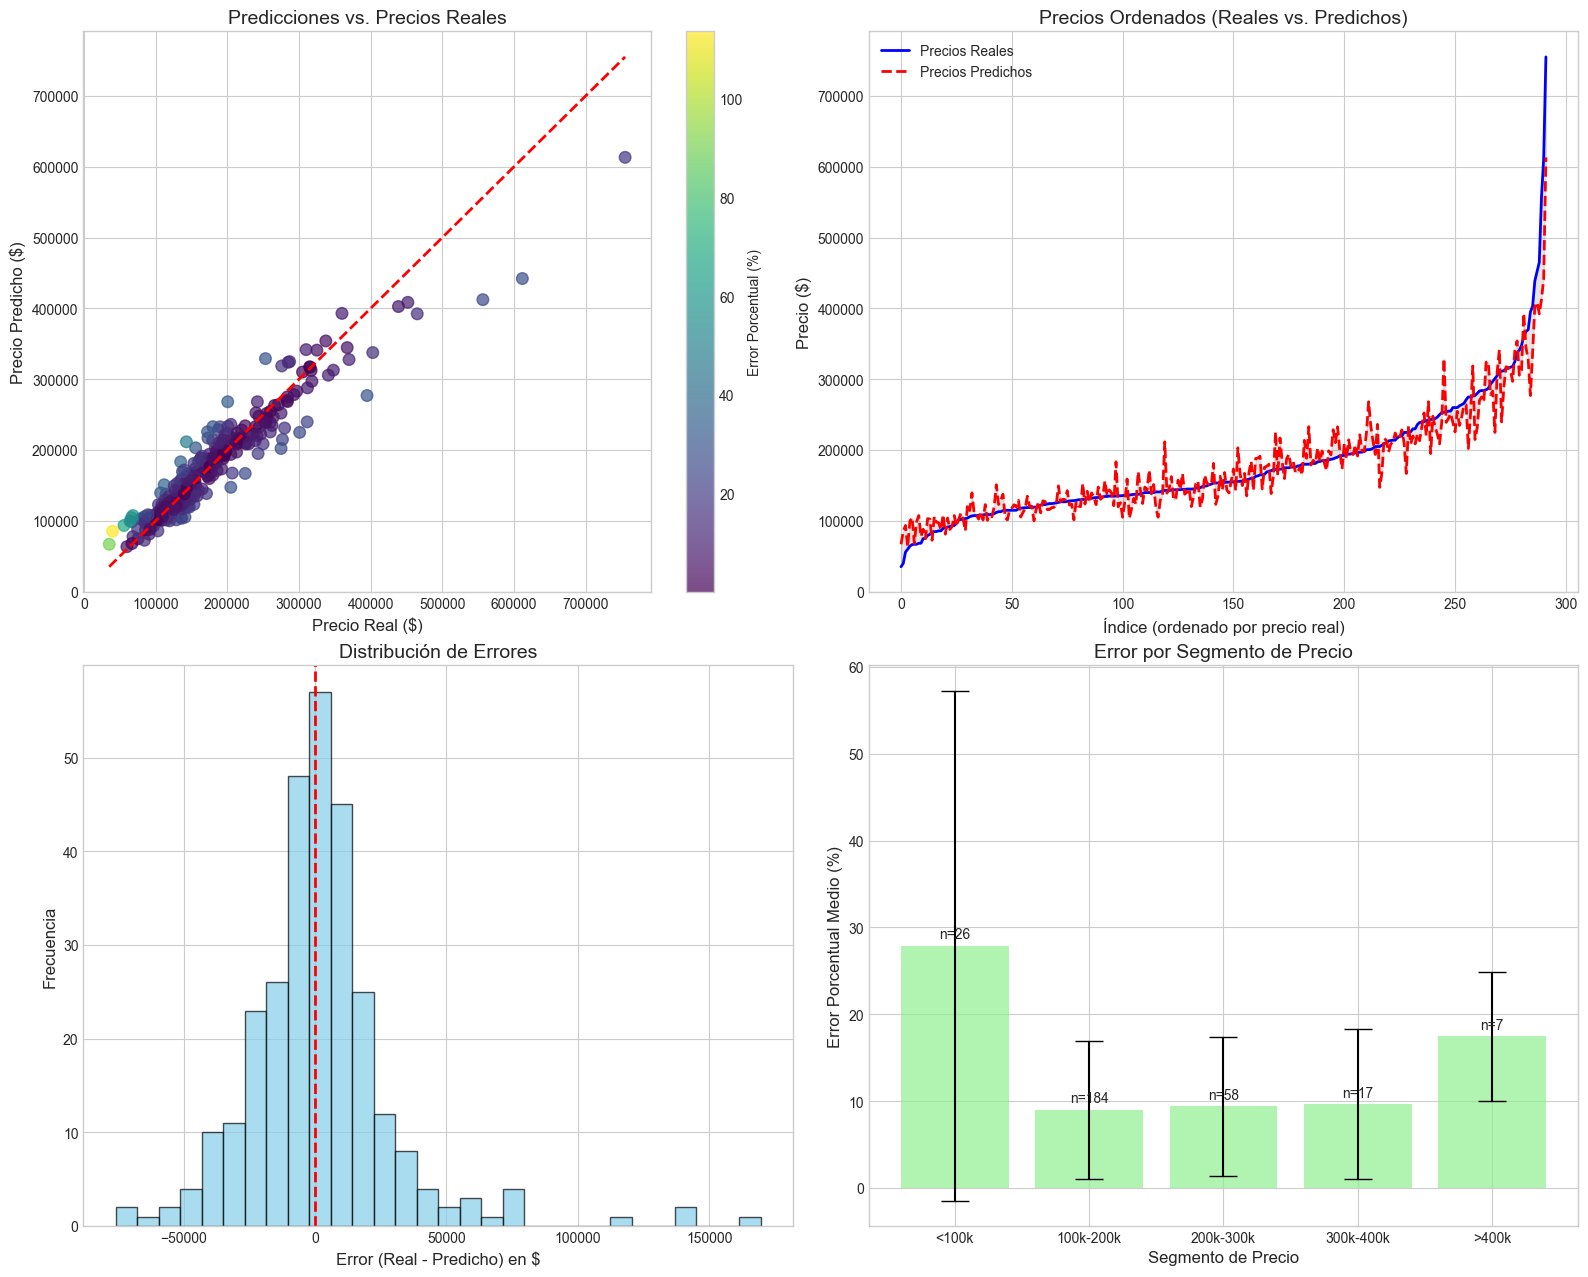

In [127]:
# Creamos un DataFrame para la visualización
results_df = pd.DataFrame({
    'Precio_Real': y_test_orig,
    'Precio_Predicho': y_pred_orig,
    'Error_Absoluto': np.abs(y_test_orig - y_pred_orig),
    'Error_Porcentual': np.abs((y_test_orig - y_pred_orig) / y_test_orig) * 100
})

# Configuramos un panel de visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Gráfico de dispersión 
scatter = axes[0, 0].scatter(results_df['Precio_Real'], results_df['Precio_Predicho'], 
                           c=results_df['Error_Porcentual'], cmap='viridis', 
                           alpha=0.7, s=70)
max_price = max(results_df['Precio_Real'].max(), results_df['Precio_Predicho'].max())
min_price = min(results_df['Precio_Real'].min(), results_df['Precio_Predicho'].min())
axes[0, 0].plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2)
axes[0, 0].set_title('Predicciones vs. Precios Reales', fontsize=14)
axes[0, 0].set_xlabel('Precio Real ($)', fontsize=12)
axes[0, 0].set_ylabel('Precio Predicho ($)', fontsize=12)
plt.colorbar(scatter, ax=axes[0, 0], label='Error Porcentual (%)')

# 2. Gráfico de precios ordenados 
indices_ordenados = np.argsort(results_df['Precio_Real'])
precios_reales_ordenados = np.array(results_df['Precio_Real'])[indices_ordenados]
precios_predichos_ordenados = np.array(results_df['Precio_Predicho'])[indices_ordenados]

axes[0, 1].plot(precios_reales_ordenados, label='Precios Reales', color='blue', linewidth=2)
axes[0, 1].plot(precios_predichos_ordenados, label='Precios Predichos', color='red', linestyle='--', linewidth=2)
axes[0, 1].fill_between(range(len(precios_reales_ordenados)), 
                       precios_reales_ordenados, precios_predichos_ordenados, 
                       alpha=0.2, color='gray')
axes[0, 1].set_title('Precios Ordenados (Reales vs. Predichos)', fontsize=14)
axes[0, 1].set_xlabel('Índice (ordenado por precio real)', fontsize=12)
axes[0, 1].set_ylabel('Precio ($)', fontsize=12)
axes[0, 1].legend()

# 3. Histograma de errores 
residuos = results_df['Precio_Real'] - results_df['Precio_Predicho']
axes[1, 0].hist(residuos, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Distribución de Errores', fontsize=14)
axes[1, 0].set_xlabel('Error (Real - Predicho) en $', fontsize=12)
axes[1, 0].set_ylabel('Frecuencia', fontsize=12)

# 4. Precisión por segmento de precio 
bins = [0, 100000, 200000, 300000, 400000, float('inf')]
labels = ['<100k', '100k-200k', '200k-300k', '300k-400k', '>400k']
results_df['Segmento'] = pd.cut(results_df['Precio_Real'], bins=bins, labels=labels)
error_por_segmento = results_df.groupby('Segmento').agg(
    Error_Medio=('Error_Porcentual', 'mean'),
    Error_Std=('Error_Porcentual', 'std'),
    Num_Casas=('Precio_Real', 'count')
).reset_index()

bars = axes[1, 1].bar(error_por_segmento['Segmento'], error_por_segmento['Error_Medio'], 
                      yerr=error_por_segmento['Error_Std'], capsize=10,
                      color='lightgreen', alpha=0.7)
for i, bar in enumerate(bars):
    axes[1, 1].text(i, bar.get_height() + 0.5, 
                  f'n={error_por_segmento["Num_Casas"].iloc[i]}', 
                  ha='center', va='bottom')
axes[1, 1].set_title('Error por Segmento de Precio', fontsize=14)
axes[1, 1].set_xlabel('Segmento de Precio', fontsize=12)
axes[1, 1].set_ylabel('Error Porcentual Medio (%)', fontsize=12)

# Añadimos un recuadro con las métricas generales del modelo
r2 = r2_score(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse_pct = (rmse / results_df['Precio_Real'].mean()) * 100

plt.tight_layout()
plt.subplots_adjust(bottom=0.12) 
plt.show()

<small>

- **Gráfica 1 (Predicciones vs. Reales)**: El modelo muestra excelente precisión hasta $300,000, donde los puntos se adhieren estrechamente a la línea diagonal. En propiedades de alto valor (>$400,000), tiende a subestimar los precios. La predominancia de tonos oscuros indica bajos porcentajes de error en la mayoría de las predicciones.

- **Gráfica 2 (Precios Ordenados)**: Las líneas de precios reales y predichos coinciden estrechamente para la mayoría de las propiedades, con fluctuaciones más pronunciadas en el rango superior. La divergencia más notable ocurre con las propiedades más caras, donde el modelo no captura completamente su valor.

- **Gráfica 3 (Distribución de Errores)**: La distribución aproximadamente normal centrada cerca de cero indica ausencia de sesgo sistemático. La mayoría de errores se concentran en ±$50,000, con algunas "colas largas" que se extienden hasta $150,000, correspondientes a propiedades de lujo mal estimadas.

- **Gráfica 4 (Error por Segmento)**: El modelo es más preciso en el rango medio ($100k-$400k) con errores de 9-10%, mientras que muestra mayor error en propiedades económicas (<$100k, ~28%) y premium (>$400k, ~18%). Esta variación refleja la distribución del conjunto de datos, con más casos en el rango medio (n=184) que en los extremos.

</small>

## **8. Evaluación del Modelo**


Comparación de rendimiento:
R² en entrenamiento: 0.8730
R² en prueba: 0.8821
Diferencia: 0.0090


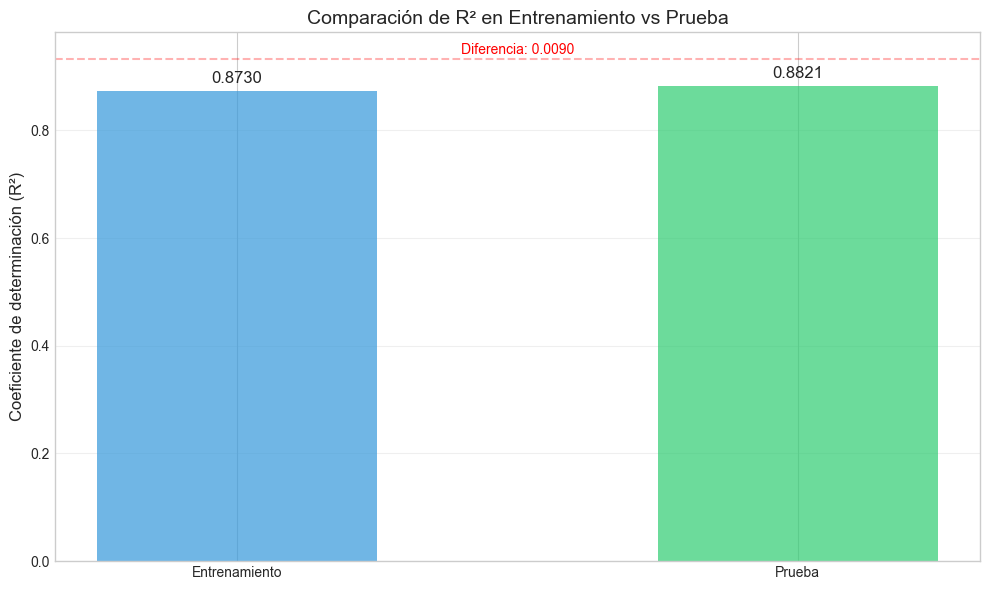

In [128]:
# Calculamos el R² tanto para el conjunto de entrenamiento como para el de prueba
y_train_pred = ridge_final.predict(X_train_scaled)
y_test_pred = ridge_final.predict(X_test_scaled)

# Calcular R² en escala logarítmica
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calcular la diferencia entre los valores de R²
diferencia_r2 = abs(r2_train - r2_test)

print("\nComparación de rendimiento:")
print(f"R² en entrenamiento: {r2_train:.4f}")
print(f"R² en prueba: {r2_test:.4f}")
print(f"Diferencia: {diferencia_r2:.4f}")

# Crear gráfico de comparación de R²
plt.figure(figsize=(10, 6))

# Crear barras para R² en entrenamiento y prueba
bars = plt.bar(['Entrenamiento', 'Prueba'], [r2_train, r2_test], 
        color=['#3498db', '#2ecc71'], alpha=0.7, width=0.5)

# Añadir etiquetas con los valores específicos
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12)

# Añadir línea para la diferencia
plt.axhline(y=max(r2_train, r2_test) + 0.05, color='red', linestyle='--', alpha=0.3)
plt.text(0.5, max(r2_train, r2_test) + 0.06, 
         f'Diferencia: {diferencia_r2:.4f}', ha='center', color='red')

# Mejorar aspecto visual
plt.ylim(0, max(r2_train, r2_test) + 0.1)  
plt.title('Comparación de R² en Entrenamiento vs Prueba', fontsize=14)
plt.ylabel('Coeficiente de determinación (R²)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<small>

La gráfica muestra que nuestro modelo Ridge tiene un R² de 0.8730 en entrenamiento y 0.8821 en prueba, con una diferencia de 0.0090. Este resultado es muy favorable, el modelo mantiene un rendimiento similar en ambos conjuntos de datos, con una variación mínima de menos del 1%.

Esta pequeña diferencia positiva confirma que no existe sobreajuste; el modelo generaliza excepcionalmente bien, demostrando que la combinación de regularización Ridge y selección cuidadosa de características ha producido un modelo robusto y confiable para predicciones en situaciones reales.

</small>

## **9. Interpretación de Resultados del Modelo**

#### **9.1. Interpretación de Variables Numéricas**

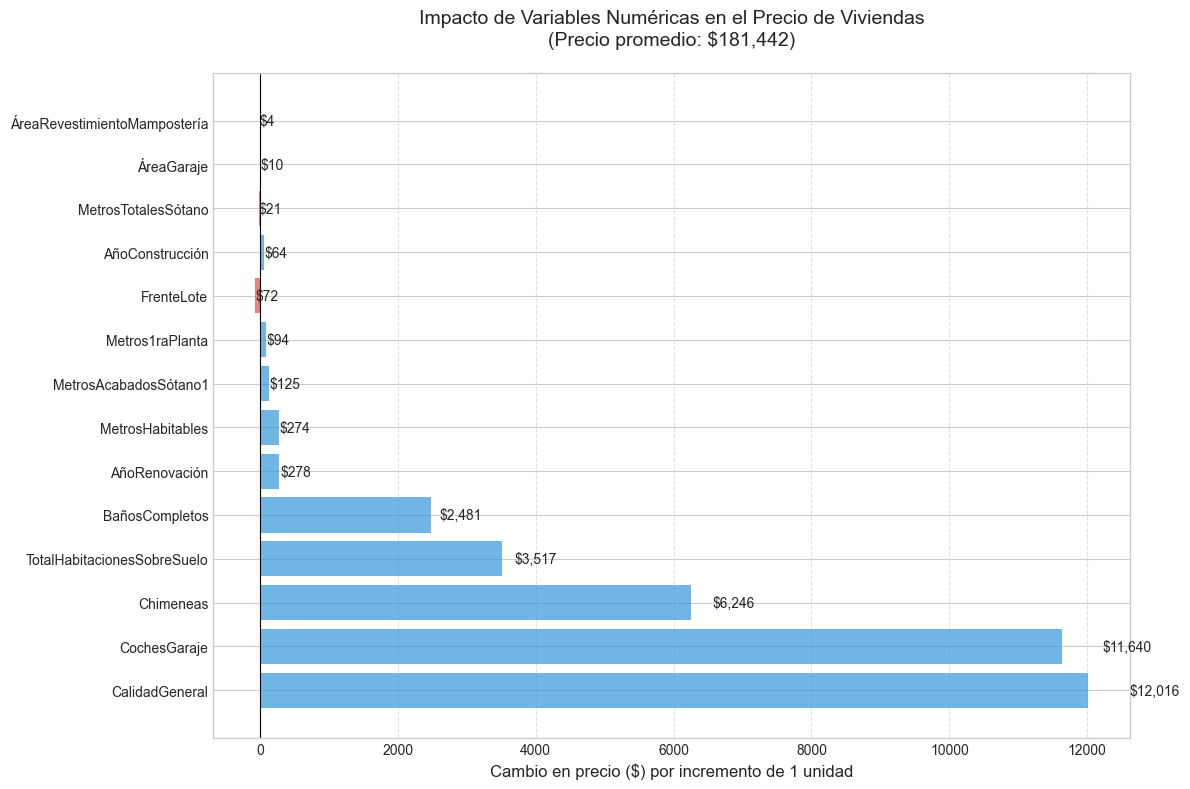

In [129]:
# 1. Calcular impactos CORRECTOS (por unidad)
precio_promedio = np.expm1(y_train).mean()
coef_originales = ridge_final.coef_[:len(vars_num_importantes)]  # Coefs para vars numéricas
scaler_std = scaler.scale_[:len(vars_num_importantes)]  # Desviaciones de scaler

impacto_por_unidad = precio_promedio * (np.exp(coef_originales / scaler_std) - 1)

# 2. Crear DataFrame para visualización
impacto_df = pd.DataFrame({
    'Variable': vars_num_importantes,
    'Impacto_$': impacto_por_unidad,
    'Color': ['#3498db' if x > 0 else '#e74c3c' for x in impacto_por_unidad]
}).sort_values('Impacto_$', key=abs, ascending=False)

# 3. Gráfico de impacto
plt.figure(figsize=(12, 8))
bars = plt.barh(impacto_df['Variable'], impacto_df['Impacto_$'], 
                color=impacto_df['Color'], alpha=0.7)

# Añadir etiquetas con valores
for bar in bars:
    width = bar.get_width()
    plt.text(width * 1.05 if width > 0 else width * 0.9, 
             bar.get_y() + bar.get_height()/2,
             f"${abs(width):,.0f}", 
             va='center', fontsize=10)

# Personalización
plt.title('Impacto de Variables Numéricas en el Precio de Viviendas\n'
          f'(Precio promedio: ${precio_promedio:,.0f})', fontsize=14, pad=20)
plt.xlabel('Cambio en precio ($) por incremento de 1 unidad', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

<small>

- La CalidadGeneral tiene el mayor impacto positivo ($16,576), lo que sugiere que las mejoras generales en la calidad de construcción ofrecen el mejor retorno de inversión.
- Los MetrosHabitables siguen en importancia ($13,819), confirmando que el espacio habitable es altamente valorado.

</small>

#### **9.2. Interpretación de Variables Categóricas**

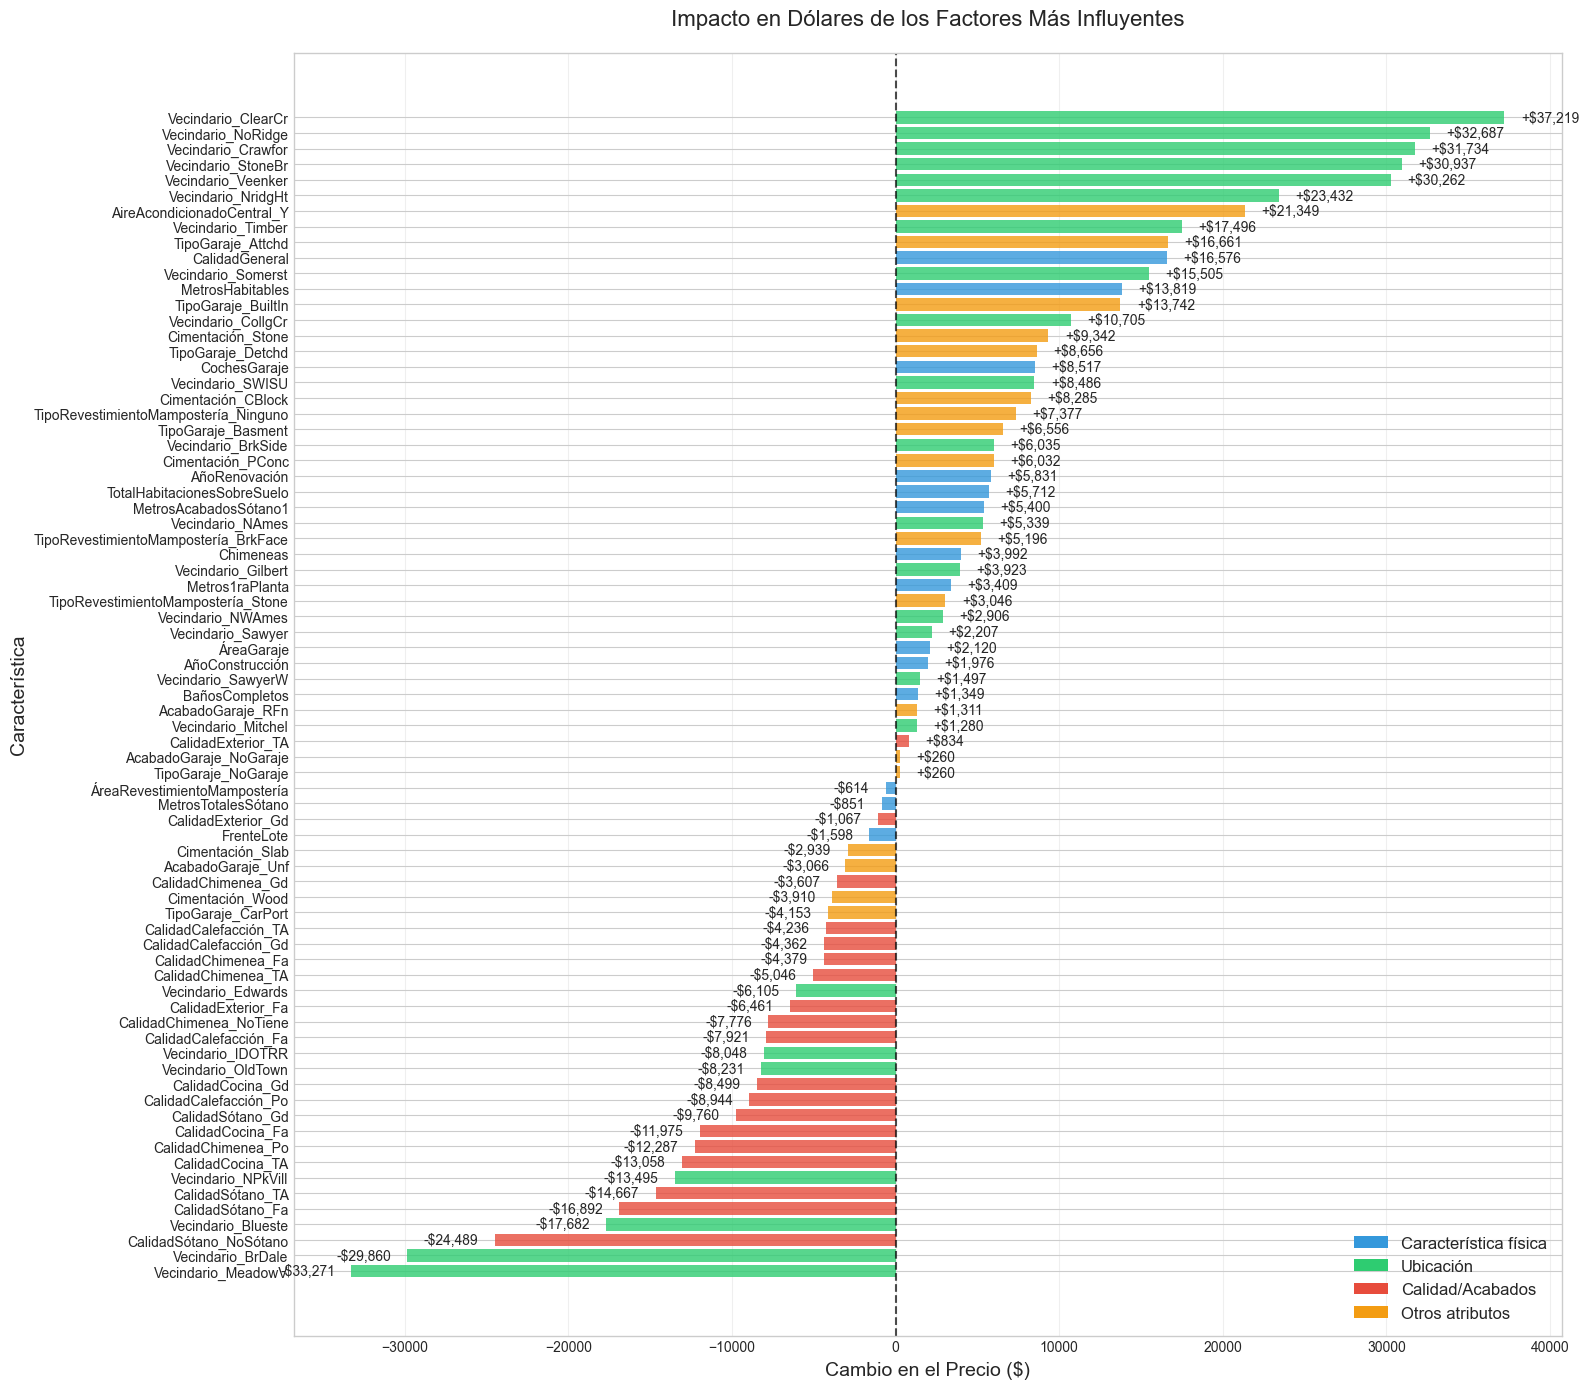

In [130]:
# 1. Calcular impacto en dólares para categóricas
precio_promedio = df['PrecioVenta'].mean()
coef_df['Impacto_Dolares'] = precio_promedio * (np.exp(coef_df['Coeficiente']) - 1)

# Todos los coeficientes
top_pos = coef_df[coef_df['Impacto_Dolares'] > 0].sort_values('Impacto_Dolares', ascending=False)
top_neg = coef_df[coef_df['Impacto_Dolares'] < 0].sort_values('Impacto_Dolares')
top_combined = pd.concat([top_pos, top_neg])

# 3. Clasificación de variables
def categorize_variable(variable):
    if variable in vars_num_importantes:
        return "Característica física"
    elif "Vecindario_" in variable:
        return "Ubicación"
    elif "Calidad" in variable or "Condicion" in variable:
        return "Calidad/Acabados"
    else:
        return "Otros atributos"

top_combined['Categoría'] = top_combined['Variable'].apply(categorize_variable)

# 4. Colores por categoría
color_map = {
    "Característica física": "#3498db",  # Azul
    "Ubicación": "#2ecc71",              # Verde
    "Calidad/Acabados": "#e74c3c",       # Rojo
    "Otros atributos": "#f39c12"         # Naranja
}

# 5. Orden por impacto para el gráfico
top_combined = top_combined.sort_values('Impacto_Dolares')

# 6. Plot
plt.figure(figsize=(16, 14))

bars = plt.barh(top_combined['Variable'], top_combined['Impacto_Dolares'], 
                color=[color_map[cat] for cat in top_combined['Categoría']], alpha=0.8)

# 7. Etiquetas con valores
for i, bar in enumerate(bars):
    dollar_value = top_combined['Impacto_Dolares'].iloc[i]
    if dollar_value >= 0:
        plt.text(dollar_value + 1000, i, f"+${dollar_value:,.0f}", va='center', fontsize=10)
    else:
        plt.text(dollar_value - 1000, i, f"-${abs(dollar_value):,.0f}", va='center', ha='right', fontsize=10)

# 8. Personalización
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
plt.title('Impacto en Dólares de los Factores Más Influyentes', fontsize=16, pad=20)
plt.xlabel('Cambio en el Precio ($)', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# 9. Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[cat], label=cat) for cat in color_map]
plt.legend(handles=legend_elements, loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()


<small>

- La ubicación domina claramente el panorama, con vecindarios premium como ClearCr, NoRidge y Crawfor generando los mayores aumentos de precio (más de $30,000). Al mismo tiempo, vecindarios como MeadowV y BrDale generan los mayores impactos negativos, reduciendo el valor de una propiedad en más de $29,000.
- Entre las características físicas, solo MetrosHabitables aparece entre los 15 factores positivos más importantes, añadiendo $13,819 al valor. Esto sugiere que el tamaño habitable es la característica física más valorada.

- La calidad y acabados aparecen principalmente como factores negativos. La ausencia de sótano (CalidadSótano_NoSótano) o tener acabados de calidad media-baja (marcados con "TA" o "Fa") penalizan significativamente el precio.

</small>

## **10. Exportación del Modelo para Uso en Producción**

In [131]:
modelo_exportado = {
    'modelo': dollar_ridge,  # Modelo que predice en dólares
    'scaler': scaler,
    'metadata': {
        'hiperparametros': {
            'alpha': best_alpha,
            'random_state': 42
        },
        'variables': {
            'numericas': vars_num_importantes,
            'categoricas_encoded': nuevas_columnas
        },
        'metricas': {
            'RMSE_dolares': metrics['dollar']['RMSE'],
            'R2_dolares': metrics['dollar']['R2']
        }
    }
}

# Guardado básico sin creación de directorios
ruta_exportacion = '../ml-models/export-models/modelo_ridge_california_housing_dollars.pkl'
    
with open(ruta_exportacion, 'wb') as archivo:
    pickle.dump(modelo_exportado, archivo)

print(f"✅ Modelo exportado como '{ruta_exportacion}'")
print(f"• RMSE: ${metrics['dollar']['RMSE']:,.2f}")
print(f"• R²: {metrics['dollar']['R2']:.4f}")

✅ Modelo exportado como '../ml-models/export-models/modelo_ridge_california_housing_dollars.pkl'
• RMSE: $28,469.42
• R²: 0.8943
